In [72]:
import pandas as pd

df_gait = pd.read_csv('gait.csv')
print(df_gait.head)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [73]:
# Pivot the dataframe to make the 'time' values become columns
df = df_gait.pivot_table(
    index=['subject', 'condition', 'replication', 'leg', 'joint'],
    columns='time', 
    values='angle'
)

df.reset_index(inplace=True)

df.columns = ['subject', 'condition', 'replication', 'leg', 'joint'] + [f'time_{int(col)}' for col in df.columns[5:]]

df.to_csv('transformed_gait_data.csv', index=False)

print(df.head())

   subject  condition  replication  leg  joint     time_0     time_1  \
0        1          1            1    1      1   4.682881   5.073127   
1        1          1            1    1      2   3.693683   4.258876   
2        1          1            1    1      3  16.607868  16.851029   
3        1          1            1    2      1   5.015829   5.291201   
4        1          1            1    2      2   2.244425   3.381678   

      time_2     time_3     time_4  ...    time_91    time_92    time_93  \
0   5.229774   5.083273   4.652399  ...   9.876782   8.725667   7.628732   
1   5.346945   6.769831   8.351716  ...  29.831388  25.253682  20.560889   
2  17.170098  17.504693  17.806602  ...  21.228337  20.821052  20.216791   
3   5.410528   5.270628   4.814143  ...   5.991338   5.369366   4.895390   
4   4.925566   6.623978   8.268602  ...  26.415806  22.453507  18.454504   

     time_94    time_95    time_96    time_97    time_98    time_99   time_100  
0   6.736811   6.152976   5.9

In [74]:
print(df.shape)

(1800, 106)


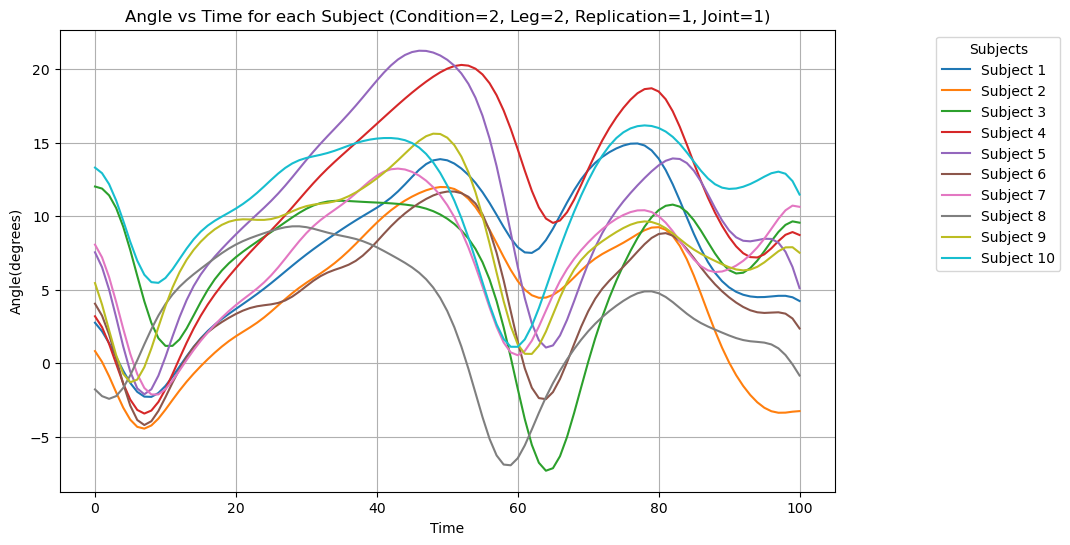

In [75]:
import matplotlib.pyplot as plt

filtered_df = df_pivot[(df_pivot['condition'] == 2) & 
                       (df_pivot['leg'] == 2) & 
                       (df_pivot['replication'] == 1) & 
                       (df_pivot['joint'] == 1)]

plt.figure(figsize=(10, 6))

time_points = [f'time_{i}' for i in range(101)]

for index, row in filtered_df.iterrows():
    plt.plot(range(101), row[time_points], label=f'Subject {int(row["subject"])}')

plt.xlabel('Time')
plt.ylabel('Angle(degrees)')
plt.title('Angle vs Time for each Subject (Condition=2, Leg=2, Replication=1, Joint=1)')
plt.legend(title="Subjects", loc="upper right", bbox_to_anchor=(1.3, 1))
plt.grid()

plt.show()

In [76]:
import seaborn as sns

pivot_df_no_replication = df.groupby(['condition', 'leg', 'joint']).angle.mean().unstack(level=[0, 1])

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_df_no_replication, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Average Angle(degrees) by Condition, Leg, and Joint")
plt.xlabel("Condition-Leg Combination")
plt.ylabel("Joint")
plt.show()


AttributeError: 'DataFrameGroupBy' object has no attribute 'angle'

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\qingqing\AppData\Local\Temp\ipykernel_12060\15561587.py:4: SyntaxWarning: invalid escape sequence '\d'
  df['time'] = df['time'].str.extract('(\d+)').astype(int)


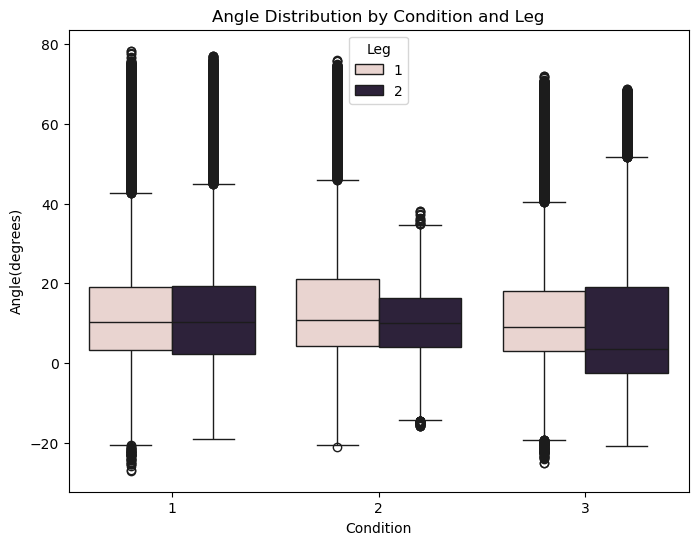

In [77]:
df = df_pivot.melt(id_vars=['subject', 'condition', 'replication', 'leg', 'joint'],
                   var_name='time', value_name='angle')

df['time'] = df['time'].str.extract('(\d+)').astype(int)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='condition', y='angle', hue='leg')
plt.title("Angle Distribution by Condition and Leg")
plt.xlabel("Condition")
plt.ylabel("Angle(degrees)")
plt.legend(title="Leg")
plt.show()

In [62]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['subject'])
y = df['subject']

X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.6, random_state=22, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size=0.2, random_state=22, stratify=y_other)

print("Training set shape (X):", X_train.shape)
print("Test set shape (X):", X_test.shape)
print("Validation set shape (X):", X_val.shape)
print("Training set shape (y):", y_train.shape)
print("Test set shape (y):", y_test.shape)
print("Validation set shape (y):", y_val.shape)


Training set shape (X): (1080, 105)
Test set shape (X): (576, 105)
Validation set shape (X): (144, 105)
Training set shape (y): (1080,)
Test set shape (y): (576,)
Validation set shape (y): (144,)


In [57]:
from sklearn.preprocessing import OneHotEncoder

onehot_ftrs = ['condition','replication','leg','joint']

enc = OneHotEncoder(sparse_output=False,handle_unknown='ignore') 

enc.fit(X_train[onehot_ftrs])
print('feature names:',enc.get_feature_names_out(onehot_ftrs))
print(len(enc.get_feature_names_out(onehot_ftrs)))

feature names: ['condition_1' 'condition_2' 'condition_3' 'replication_1' 'replication_2'
 'replication_3' 'replication_4' 'replication_5' 'replication_6'
 'replication_7' 'replication_8' 'replication_9' 'replication_10' 'leg_1'
 'leg_2' 'joint_1' 'joint_2' 'joint_3']
18


In [58]:
# transform X_train
onehot_train = enc.transform(X_train[onehot_ftrs])
print('transformed train features:')
print(onehot_train)
# transform X_val
onehot_val = enc.transform(X_val[onehot_ftrs])
print('transformed val features:')
print(onehot_val)
# transform X_test
onehot_test = enc.transform(X_test[onehot_ftrs])
print('transformed test features:')
print(onehot_test)

transformed train features:
[[0. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]]
transformed val features:
[[1. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]]
transformed test features:
[[1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 1. 0. 0.]]


In [60]:
from sklearn.preprocessing import StandardScaler

time_columns = [f'time_{i}' for i in range(101)]

scaler = StandardScaler()

X_train[time_columns] = scaler.fit_transform(X_train[time_columns])
X_val[time_columns] = scaler.transform(X_val[time_columns])
X_test[time_columns] = scaler.transform(X_test[time_columns])

print(X_train[time_columns].head())

        time_0    time_1    time_2    time_3    time_4    time_5    time_6  \
1323 -1.213105 -1.267062 -1.300689 -1.292211 -1.235211 -1.140990 -1.031126   
391  -1.329393 -1.341390 -1.301369 -1.211552 -1.082927 -0.933566 -0.781442   
1031  1.682880  1.676273  1.667437  1.655626  1.639772  1.619928  1.596749   
806   1.478218  1.448115  1.427995  1.414808  1.404063  1.392387  1.378258   
1230 -0.167069 -0.137526 -0.139714 -0.174463 -0.240150 -0.331043 -0.437758   

        time_7    time_8    time_9  ...   time_91   time_92   time_93  \
1323 -0.926761 -0.842098 -0.783134  ... -1.414636 -1.401872 -1.361966   
391  -0.637914 -0.506170 -0.383481  ...  0.308409  0.093222 -0.140877   
1031  1.570627  1.541908  1.511447  ...  1.062396  1.240043  1.416583   
806   1.361470  1.342721  1.323538  ...  0.861983  1.010797  1.153822   
1230 -0.549678 -0.657576 -0.755209  ... -0.953894 -0.928948 -0.886254   

       time_94   time_95   time_96   time_97   time_98   time_99  time_100  
1323 -1.295820 

In [64]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

onehot_ftrs = ['condition','replication','leg','joint']
std_ftrs = [f'time_{i}' for i in range(101)]

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)



(1080, 105)
(1080, 119)
[[ 0.          1.          0.         ... -1.04186784 -1.06080697
  -1.11844829]
 [ 1.          0.          0.         ... -1.18620173 -1.28436054
  -1.33627862]
 [ 0.          0.          1.         ...  1.85262553  1.84594247
   1.83406373]
 ...
 [ 0.          1.          0.         ... -0.1994273  -0.12017408
  -0.04800674]
 [ 0.          0.          1.         ... -0.27802923 -0.47736116
  -0.61495024]
 [ 0.          0.          1.         ...  0.05444351 -0.10445958
  -0.22896078]]


In [65]:
print(X_train.shape)
print(X_train_prep.shape)

(1080, 105)
(1080, 119)
